In [153]:
import torch
import torch.nn as nn

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from copy import deepcopy

In [155]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/newnew_data.csv')
df['Date'] = pd.to_datetime(df['Date'])  # 'Date' 열을 datetime 객체로 변환
df.set_index('Date', inplace=True)
df

,재고순환지표,경제심리지수,기계류내수출,건설수주액,수출입물가비율,코스피,장단기,외환보유액,뉴스심리지수,원달러,...,CD,유가,G20,미장단기,거래량,구리,천연가스,은,금,종가
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,5.0,112.1,98.5,10384.8,105.1,1853.7,0.67,261870733.0,98.54,936.80,...,5.84,26.816444,101.55890,1.03,11548.0,3.06400,7.8500,15.290,860.0,1000.00
2008-02-01,3.9,112.0,98.4,9246.1,103.7,1775.3,0.53,262364808.0,97.88,944.10,...,5.46,26.276930,101.28680,1.53,13564.0,3.27300,7.7400,16.916,913.5,897.97
2008-03-01,3.2,110.5,98.4,9434.4,102.2,1691.0,0.31,264245660.0,88.12,946.70,...,5.17,26.771666,100.97430,1.93,9948.0,3.92850,9.3460,20.180,984.2,873.82
2008-04-01,0.4,109.4,98.9,10121.7,100.7,1705.8,0.14,260482546.0,103.73,983.50,...,5.39,27.311699,100.60140,1.77,13964.0,3.80650,9.7240,16.935,887.8,965.78
2008-05-01,-1.6,106.1,98.5,9955.6,98.6,1758.2,0.22,258198958.0,93.06,1009.10,...,5.36,25.481760,100.14520,1.41,16690.0,3.69450,10.5610,16.205,850.9,1056.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,-10.4,92.7,115.4,10568.5,85.2,2336.4,0.84,423163664.0,83.39,1304.21,...,4.03,76.773430,98.93524,-0.72,8411.0,3.81750,6.7380,22.841,1815.2,1435.74
2023-01-01,-15.4,90.9,111.2,13969.7,85.1,2380.4,0.45,429967671.0,93.79,1269.02,...,3.98,78.254589,98.97138,-0.61,10487.0,3.79525,4.2735,24.328,1835.8,1343.91
2023-02-01,-16.2,91.1,106.9,14725.6,84.6,2391.3,0.18,425286150.0,97.48,1221.78,...,3.59,74.513809,99.02458,-0.70,9732.0,4.11100,2.4680,23.609,1927.8,1439.49


### MinMaxScaler 적용

In [156]:
from sklearn.preprocessing import MinMaxScaler

raw_data = deepcopy(df[['재고순환지표', '경제심리지수', '수출입물가비율', '코스피', '장단기', 'CD', '거래량', '미장단기','원달러', '원엔', 'G20','구리','종가']])
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_raw_data = X_scaler.fit_transform(raw_data)
y_raw_data = y_scaler.fit_transform(raw_data['종가'].values.reshape(-1, 1))
print (X_raw_data.shape, y_raw_data.shape)

(184, 13) (184, 1)


### X_train 과 y_train 데이터 구성

In [157]:
def prepare_xy(X_raw_data, y_raw_data, lookback):
    data = list()
    for index in range(len(X_raw_data) - lookback):
        data.append(X_raw_data[index: index + lookback])
    data = np.array(data)
    return data, y_raw_data[lookback:]

In [158]:
lookback = 10 # sequence length - 1
X_train, y_train = prepare_xy(X_raw_data, y_raw_data, lookback)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
print(X_train.shape, y_train.shape)

torch.Size([174, 10, 13]) torch.Size([174, 1])


### Custom Dataset
- MNIST 데이터는 이미 잘 만들어진 데이터로, 바로 Subset, DataLoader 등 파이토치의 미니배치 구성 관련 기능을 사용할 수 있음
- raw data 를 기반으로, 파이토치의 미니배치등을 구성하려면, 위와 같이 직접 데이터셋을 작성하여, TensorDataset 을 통해, Dataset 으로 만들면 됨
- 이 기법 외에 Custom Dataset 을 구성할 수도 있음

> raw data 를 텐서로 만들어, 전체 데이터를 딥러닝 모델에 한번에 넣는 경우는 없으므로, 미니배치를 쉽게 구성하고, 반복문을 통해, 미니배치 하나씩 가져오도록 하는 구성이 필요함
> 이를 손쉽게 해주는 기능이 Subset, DataLoader 등의 기능이며, 이를 위해, raw data 를 Dataset 으로 만들어주어야 함

### Custom Dataset class
- Custom Dataset 은 클래스로 구현해야 함 (모델 구현과 유사함)
- torch.utils.data.Dataset 클래스를 상속받아야 함
- 다음 세가지 메서드가 필요함
  - \_\_init\_\_(self) : 입력 데이터(x)와 실제 값(y) 을 선언해주는 메서드
  - \_\_len\_\_(self) :입력 데이터(x)와 실제 값(y) 길이를 리턴해주는 메서드
  - \_\_getitem\_\_(self, index) : index번째 입력 데이터(x)와 실제 값(y) 을 리턴해주는 메서드

In [159]:
# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self):
#         self.X_data = X_train
#         self.y_data = y_train

#     # 총 데이터의 개수를 리턴
#     def __len__(self):
#         return len(self.X_data)

#     # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
#     def __getitem__(self, index):
#         X = self.X_data[index]
#         y = self.y_data[index]
#         return X, y

In [160]:
# train_rawdata = CustomDataset()
# train_rawdata.y_data

### TensorDataset
- TensorDataset은 Dataset을 상속한 클래스로 학습 데이터 X와 실제 값 Y를 묶어 놓는 Dataset
   - 학습 데이터와 실제 값을 하나로 묶어서, 인덱스, 반복문을 통한 각 데이터 추출을 편리하게 하는 기능
   - DataLoader 등 pytorch 의 데이터 전처리 기능 사용 가능
- TensorDataset으로 랩핑한 Dataset 은 DataLoader 로 미니배치를 쉽게 작성할 수 있음
- tensors() 메서드로 각 텐서를 인덱스 번호로 엑세스도 가능함

In [161]:
train_rawdata = TensorDataset(X_train, y_train)

In [162]:
print (train_rawdata.tensors[0].shape) # X_train
print (train_rawdata.tensors[1].shape) # y_train

torch.Size([174, 10, 13])
torch.Size([174, 1])


### Generate Train & Validation Mini-batch
- TensorDataset 으로 만든 Dataset 이든, Custom Dataset class 로 만든 Dataset 이든 모두 사용 가능

In [163]:
VALIDATION_RATE = 0.2
train_indices, val_indices = train_test_split(
    range(len(train_rawdata)), # X index 번호
    test_size=VALIDATION_RATE # test dataset 비율
)
train_dataset = Subset(train_rawdata, train_indices)
validation_dataset = Subset(train_rawdata, val_indices)

minibatch_size = 16 # Mini-batch 사이즈는 128 로 설정
# create batches
train_batches = DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_batches = DataLoader(validation_dataset, batch_size=minibatch_size, shuffle=True)

In [164]:
# 미니배치 하나만 가져와서 이미지 visualization
X_train, y_train = next(iter(train_batches))
print (X_train.shape, y_train.shape)

torch.Size([16, 10, 13]) torch.Size([16, 1])


### 모델 생성

In [165]:
class Net(nn.Module):
    def __init__(self, feature_size, hidden_size, num_layers, dropout_p, output_size, model_type='LSTM'):
        super().__init__()
        if model_type == 'LSTM':
            self.sequenceclassifier = nn.LSTM(
                input_size = feature_size,
                hidden_size = hidden_size,
                num_layers = num_layers,
                batch_first = True,
                dropout = dropout_p
            )
        elif model_type == 'GRU':
            self.sequenceclassifier = nn.GRU(
                input_size = feature_size,
                hidden_size = hidden_size,
                num_layers = num_layers,
                batch_first = True,
                dropout = dropout_p
            )
        self.fc = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        output, _ = self.sequenceclassifier(x) # |output| = (128, 10, 32)
        output = output[:, -1, :] # |output| = (128, 32)
        y = self.fc(output)
        return y

### input, output, loss, optimizer 설정

In [166]:
feature_size = 13 # 입력 차원
hidden_size = 32 # Hidden Layer 사이즈 설정처럼 설정
num_layers = 4 # stacked RNN (최대 4개까지는 Gradient Vanishing 현상이 적을 수 있으므로)
dropout_p = 0.1 # dropout rate
output_size = 1

model = Net(feature_size, hidden_size, num_layers, dropout_p, output_size, 'GRU')
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

### training 함수 선언

In [167]:
def train_model(model, early_stop, n_epochs, progress_interval):

    train_losses, valid_losses, lowest_loss = list(), list(), np.inf

    for epoch in range(n_epochs):

        train_loss, valid_loss = 0, 0

        # train the model
        model.train() # prep model for training
        for x_minibatch, y_minibatch in train_batches:
            y_minibatch_pred = model(x_minibatch)
            loss = loss_func(y_minibatch_pred, y_minibatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / len(train_batches)
        train_losses.append(train_loss)

        # validate the model
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in val_batches:
                y_minibatch_pred = model(x_minibatch)
                loss = loss_func(y_minibatch_pred, y_minibatch)
                valid_loss += loss.item()

        valid_loss = valid_loss / len(val_batches)
        valid_losses.append(valid_loss)

        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_epoch = epoch
            best_model = deepcopy(model.state_dict())
        else:
            if (early_stop > 0) and lowest_epoch + early_stop < epoch:
                print ("Early Stopped", epoch, "epochs")
                break

        if (epoch % progress_interval) == 0:
            print (train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch)

    model.load_state_dict(best_model)
    return model, lowest_loss, train_losses, valid_losses

In [168]:
nb_epochs = 100
progress_interval = 3
early_stop = 30

model, lowest_loss, train_losses, valid_losses = train_model(model, early_stop, nb_epochs, progress_interval)

0.34548286183012855 0.16674974219252667 0.16674974219252667 0 0
0.06702122920089298 0.1665923868616422 0.1665923868616422 3 3
0.04131482417384783 0.18813819686571756 0.13543856019775072 5 6
0.041688950111468635 0.06075711672504743 0.06075711672504743 9 9
0.03994825089143382 0.01892344281077385 0.01892344281077385 12 12
0.023977948870095942 0.011234079410011569 0.011234079410011569 15 15
0.02816574192709393 0.012153345004965862 0.011234079410011569 15 18
0.03618327880071269 0.012339160156746706 0.011234079410011569 15 21
0.023945815861225128 0.01097183565919598 0.009816439123824239 22 24
0.017555767877234355 0.013617783319205046 0.009816439123824239 22 27
0.028420499939885404 0.01695628184825182 0.009816439123824239 22 30
0.0184189323335886 0.010361099150031805 0.009816439123824239 22 33
0.029929054901003838 0.012226544010142485 0.009816439123824239 22 36
0.019903701005710497 0.012840521056205034 0.009816439123824239 22 39
0.018410184213684663 0.012774356951316198 0.009816439123824239 2

### 테스트
- torch.cat(합칠텐서리스트, 합치는 차원)
   - 합칠텐서 리스트는 기본적으로는 튜플 형태로 넣어야 하지만, 리스트도 가능함

In [169]:
print (torch.cat([torch.randn(24, 128, 1), torch.randn(24, 128, 1), torch.randn(24, 128, 1)], 0).shape)
print (torch.cat([torch.randn(24, 128, 1), torch.randn(24, 128, 1), torch.randn(24, 128, 1)], 1).shape)
print (torch.cat([torch.randn(24, 128, 1), torch.randn(24, 128, 1), torch.randn(24, 128, 1)], 2).shape)

torch.Size([72, 128, 1])
torch.Size([24, 384, 1])
torch.Size([24, 128, 3])


In [170]:
test_batches = DataLoader(train_rawdata, batch_size=minibatch_size, shuffle=False)
y_test_pred_list, y_test_list = list(), list()
model.eval()
with torch.no_grad():
    for x_minibatch, y_minibatch in test_batches:
        y_minibatch_pred = model(x_minibatch)
        y_test_pred_list.append(y_minibatch_pred)
        y_test_list.append(y_minibatch)
y_test_preds = torch.cat(y_test_pred_list, 0)
y_tests = torch.cat(y_test_list, 0)
print (y_test_preds.shape, y_tests.shape)

torch.Size([174, 1]) torch.Size([174, 1])


### 데이터 스케일 복원

In [171]:
predict = pd.DataFrame(y_scaler.inverse_transform(np.array(y_test_preds)))
original = pd.DataFrame(y_scaler.inverse_transform(np.array(y_tests)))

In [172]:
predict

,0
0,614.189209
1,593.390442
2,574.062988
3,572.824768
4,610.116943
...,...
169,1463.196167
170,1441.534546
171,1412.677612
172,1383.056396


### Metrics

In [173]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(original[0], predict[0])**0.5
print (RMSE)

86.08205739565447


### 시각화

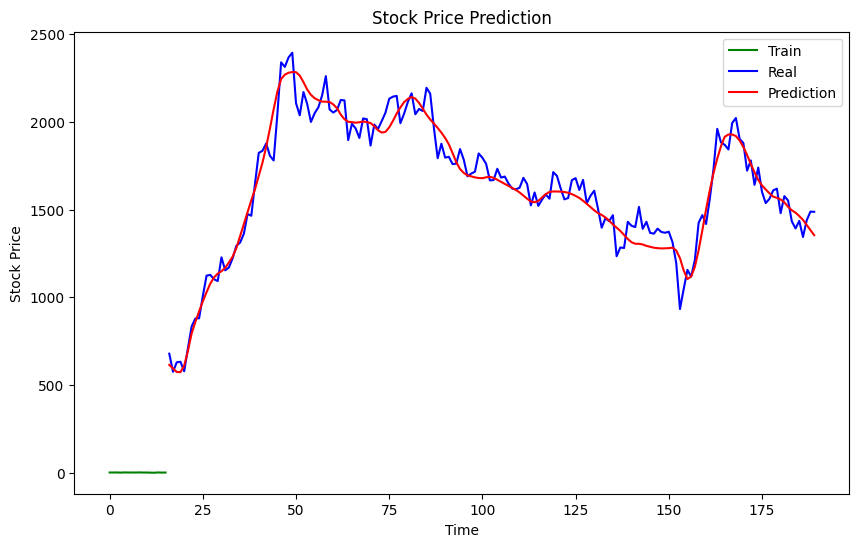

In [174]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))

# Add the training set to the plot:
plt.plot(y_train.numpy().flatten(), color='green', label='Train')

# Plot the test and prediction data:
plt.plot(range(len(y_train), len(y_train)+len(original)), original, color='blue', label='Real')
plt.plot(range(len(y_train), len(y_train) + len(original)), predict, color='red', label='Prediction')

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [175]:
import torch
from captum.attr import IntegratedGradients

# Integrated Gradients 객체 생성
ig = IntegratedGradients(model)

# 입력 데이터 준비
input_data = X_train.requires_grad_()  # Gradient 계산을 위해 requires_grad 속성을 True로 설정

# Baseline (참조점) 설정
# 여기서는 입력 데이터의 각 피쳐의 최소값을 기준으로 사용합니다.
baseline = torch.zeros_like(input_data)

# Integrated Gradients 계산
attr, delta = ig.attribute(input_data, baseline, target=0, return_convergence_delta=True)

# 속성 중요도 확인
attr = attr.detach().numpy()

# 평균 중요도 계산
avg_attr = np.average(attr, axis=0)

In [176]:
import numpy as np

# Set the print options.
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.6f}'.format})
avg_attr2 = np.average(avg_attr, axis=0)
avg_attr2

array([0.000420, -0.009555, -0.000429, 0.001265, -0.002058, 0.018280,
       -0.000692, 0.017317, -0.010278, 0.000928, 0.036113, 0.002405,
       0.007051])

In [177]:
import shap

# LSTM 모델을 정의하고 훈련시킵니다.
# model = ...

# LSTM 모델에 대한 SHAP Explainer를 초기화합니다.
explainer = shap.DeepExplainer(model, X_train)

# 테스트 세트에 대한 SHAP 값을 계산합니다.
shap_values = explainer.shap_values(X_test)

# SHAP summary plot을 그립니다.
shap.summary_plot(shap_values, X_test)

NameError: ignored